# InfoGAN with MNIST

* `InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets` [arXiv:1606.03657](https://arxiv.org/abs/1606.03657)
  * Xi Chen, Yan Duan, Rein Houthooft, John Schulman, Ilya Sutskever, Pieter Abbeel
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) and [`eager execution`](https://www.tensorflow.org/guide/eager).

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

sys.path.append(os.path.dirname(os.path.abspath('.')))
from utils.image_utils import *
from utils.ops import *

os.environ["CUDA_VISIBLE_DEVICES"]="0"
# tf.debugging.set_log_device_placement(True)

## Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'infogan'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 50
save_model_epochs = 10
print_steps = 100
save_images_epochs = 1
batch_size = 128
learning_rate_D = 2e-4
learning_rate_G = 1e-3
k = 1 # the number of step of learning D before learning G
num_classes = 10 # number of classes for (or fashion-) MNIST
num_examples_to_generate = num_classes
noise_dim = 62
categorical_code_dim = num_classes # for (or fashion-) MNIST
continuous_code_dim = 2

## Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
#train_images = train_images / 255. # Normalize the images to [0, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_labels = train_labels.astype(np.int32)

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
#tf.random.set_seed(219)
# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: (128, 28, 28, 1), types: tf.float32>


## Create the generator and discriminator models

In [5]:
class Generator(tf.keras.Model):
  """Build a generator that maps latent space to real space
    given categorical conditions and continuous condtions
    G(z, cat_code, cont_code): (z, c1, c2) -> x
  """
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = Dense(units=1024)
    self.fc2 = Dense(units=7 * 7 * 128)
    self.conv1 = ConvTranspose(64, 4)
    self.conv2 = ConvTranspose(1, 4, apply_batchnorm=False, activation='tanh')

  def call(self, noise_inputs, categorical_code, continuous_code, training=True):
    """Run the model."""
    # random z vector (noise dim): 62 dim
    # categorical code (for MNIST): 10 dim
    # continuous code: 2 dim
    # inputs: 62 + 10 + 2 = 74 dim
    inputs = tf.concat([noise_inputs, categorical_code, continuous_code], axis=1)

    fc1 = self.fc1(inputs, training=training)               # fc1: [1024]
    fc2 = self.fc2(fc1, training=training)                  # fc2: [7 x 7 x 128]
    fc2 = tf.reshape(fc2, [-1, 7, 7, 128])                  # fc2: [7, 7, 128]
    conv1 = self.conv1(fc2, training=training)              # conv1: [14, 14, 64]
    generated_images = self.conv2(conv1, training=training) # generated_images: [28, 28, 1]
    
    return generated_images

In [6]:
class Discriminator(tf.keras.Model):
  """Build a discriminator that discriminate real image x whether real or fake.
    D(x): x -> [0, 1]
  """
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = Conv(64, 4, 2, apply_batchnorm=False, activation='leaky_relu', leaky_relu_alpha=0.1)
    self.conv2 = Conv(128, 4, 2, activation='leaky_relu', leaky_relu_alpha=0.1)
    self.flatten = layers.Flatten()
    self.fc1 = Dense(units=1024, activation='leaky_relu', leaky_relu_alpha=0.1)
    self.fc2 = Dense(units=1, apply_batchnorm=False, activation='none')

  def call(self, image_inputs, training=True):
    """Run the model."""
    # image_inputs: [28, 28, 1]
    conv1 = self.conv1(image_inputs)              # conv1: [14, 14, 64]
    conv2 = self.conv2(conv1, training=training)  # conv2: [7, 7, 128]
    flatten = self.flatten(conv2)                 # flatten: [7 x 7 x 128]
    fc1 = self.fc1(flatten, training=training)    # fc1: [1024]
    discriminator_logits = self.fc2(fc1)          # discriminator_logits: [1]
    
    return discriminator_logits, fc1

In [7]:
class RecognitionNetwork(tf.keras.Model):
  """Build a RecognitionNetwork
  """
  def __init__(self):
    super(RecognitionNetwork, self).__init__()
    self.fc1 = Dense(units=128, activation='leaky_relu', leaky_relu_alpha=0.1)
    self.fc2 = Dense(units=categorical_code_dim + continuous_code_dim,
                     apply_batchnorm=False, activation='none')
    
  def call(self, inputs, training=True):
                                              # inputs: [1024]
    fc1 = self.fc1(inputs, training=training) # fc1: [128]
    q_output = self.fc2(fc1)                  # q_output: [10 + 2]
    q_logits = q_output[:, :categorical_code_dim] # q_logits: [10]
    q_cont = q_output[:, categorical_code_dim:] # q_cont: [2]
    
    return q_logits, q_cont

In [8]:
generator = Generator()
discriminator = Discriminator()
q_network = RecognitionNetwork()

### Plot generated image via generator network

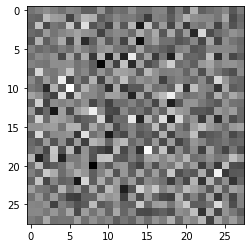

In [9]:
noise = tf.random.normal([1, noise_dim])
categorical_code = tf.convert_to_tensor([[1, 0, 0, 0, 0,
                                          0, 0, 0, 0, 0]], dtype=tf.float32)
continuous_code = tf.random.normal([1, continuous_code_dim])
generated_image = generator(noise, categorical_code, continuous_code, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Test discriminator network and Recognition network

* **CAUTION**: the outputs of discriminator is **logits** (unnormalized probability) NOT probabilites

In [ ]:
logit, recog_input = discriminator(generated_image, training=True)
q_logits, q_cont = q_network(recog_input, training=True)

print(logit)
print(recog_input)
print(q_logits)
print(q_cont)

## Define the loss functions and the optimizer

In [ ]:
# use logits for consistency with previous code I made
# `tf.losses` and `tf.keras.losses` are the same API (alias)
bce = tf.losses.BinaryCrossentropy(from_logits=True)
sfte = tf.losses.CategoricalCrossentropy(from_logits=True)
mse = tf.losses.MeanSquaredError()

In [ ]:
def GANLoss(logits, is_real=True):
  """Computes standard GAN loss between `logits` and `labels`.

  Args:
    logits (`2-rank Tensor`): logits.
    is_real (`bool`): True means `1` labeling, False means `0` labeling.

  Returns:
    loss (`0-rank Tensor`): the standard GAN loss value. (binary_cross_entropy)
  """
  if is_real:
    labels = tf.ones_like(logits)
  else:
    labels = tf.zeros_like(logits)

  return bce(labels, logits)

In [ ]:
def discriminator_loss(real_logits, fake_logits):
  # losses of real with label "1"
  real_loss = GANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = GANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss

In [ ]:
def generator_loss(fake_logits):
  # losses of Generator with label "1" that used to fool the Discriminator
  return GANLoss(logits=fake_logits, is_real=True)

In [ ]:
def mutual_information_loss(q_logits, q_cont, categorical_code, continuous_code):
  # Categorical code
  loss_Q_cate = sfte(categorical_code, q_logits)

  # Continuous code
  loss_Q_cont = tf.reduce_mean(
                  tf.reduce_sum(
                    tf.square(continuous_code - q_cont), axis=1))

  # losses of Recognition network
  return loss_Q_cate + loss_Q_cont

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate_D, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate_G, beta_1=0.5)
q_network_optimizer = tf.keras.optimizers.Adam(learning_rate_D, beta_1=0.5)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
  tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 q_network_optimizer=q_network_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 q_network=q_network)

## Training

### Define training one step function

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def discriminator_train_step(images, noise, categorical_code, continuous_code):

  with tf.GradientTape() as disc_tape:
    generated_images = generator(noise, categorical_code, continuous_code, training=True)

    real_logits, _ = discriminator(images, training=True)
    fake_logits, recog_inputs = discriminator(generated_images, training=True)
    
    disc_loss = discriminator_loss(real_logits, fake_logits)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def generator_train_step(noise, categorical_code, continuous_code):
  
  with tf.GradientTape() as gen_tape:
    generated_images = generator(noise, categorical_code, continuous_code, training=True)

    fake_logits, recog_inputs = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_logits)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
  return gen_loss

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def q_network_train_step(noise, categorical_code, continuous_code):

  with tf.GradientTape() as q_net_tape:
    generated_images = generator(noise, categorical_code, continuous_code, training=True)

    fake_logits, recog_inputs = discriminator(generated_images, training=True)
    q_logits, q_cont = q_network(recog_inputs, training=True)
    
    mi_loss = mutual_information_loss(q_logits, q_cont, categorical_code, continuous_code)

  gradients_of_q_network = q_net_tape.gradient(mi_loss, generator.trainable_variables + q_network.trainable_variables)
  q_network_optimizer.apply_gradients(zip(gradients_of_q_network, generator.trainable_variables + q_network.trainable_variables))
  
  return mi_loss

### A function for plotting

In [ ]:
def plot_samples(categorical_code=0):
    
    # get 2d continuous codes in [-1, 1]
    x = np.linspace(-1, 1, 10).astype(np.float32)
    y = np.linspace(-1, 1, 10).astype(np.float32)
    X, Y = tf.meshgrid(x, y)
    Z = tf.concat([tf.expand_dims(X, axis=-1), tf.expand_dims(Y, axis=-1)], axis=2)
    continuous_code = tf.reshape(Z, [100, 2])

    # z noise values should be equal, we make the condtinuous codes different only.
    noise = tf.random.normal([1, noise_dim])
    noise = tf.concat([noise for _ in range(100)], axis=0)
    
    categorical_code = tf.one_hot(indices=tf.ones([100,], dtype=tf.int64) * categorical_code, depth=10)
    
    generated_image = generator(noise, categorical_code, continuous_code, training=False)

    # plot image grids
    plt.figure(figsize=[10, 10])
    for x_index in range(10):
        for y_index in range(10):
            plt.subplot(10, 10, x_index + 1 + y_index * 10)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imshow(generated_image[x_index + y_index * 10, :, :, 0], cmap='gray')

    plt.show()

### Train full steps

In [ ]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)
sample_condition = tf.eye(num_classes)
  
for epoch in range(max_epochs):
  
  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    # generating noise from a uniform distribution
    noise = tf.random.uniform([batch_size, noise_dim], minval=-1.0, maxval=1.0)
    categorical_code = tf.one_hot(
                        tf.random.categorical([categorical_code_dim * [1. / categorical_code_dim]], batch_size)[0],
                              depth=categorical_code_dim)
    continuous_code = tf.random.uniform(shape=[batch_size, continuous_code_dim], minval=-1.0, maxval=1.0)
    
    disc_loss = discriminator_train_step(images, noise, categorical_code, continuous_code)
    gen_loss = generator_train_step(noise, categorical_code, continuous_code)
    mi_loss = q_network_train_step(noise, categorical_code, continuous_code)
    global_step.assign_add(1)
        
    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3g} loss_G: {:.3g} mi_loss: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), disc_loss, gen_loss, mi_loss, examples_per_sec, duration))
      
      plot_samples(np.random.randint(0, 10))